In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product k.csv', parse_dates=['Month-Year'])

In [3]:
sales_k= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_k.shape

(60, 2)

In [5]:
sales_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_k['Sales'].sum()

32299304

In [7]:
sales_k = sales_k.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_k.head()

ds       y
0 2019-01-01  505010
1 2019-02-01  521132
2 2019-03-01  580897
3 2019-04-01  612559
4 2019-05-01  550697

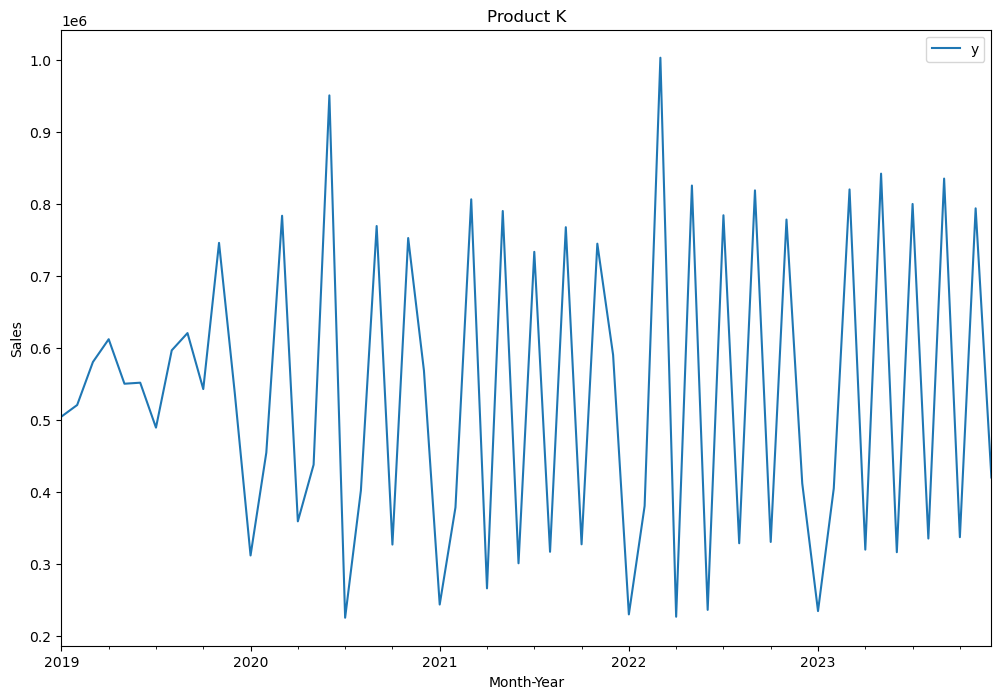

In [8]:
ax = sales_k.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product K')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_k['y'])

ADF Statistics: -4.339743021722731
p- value: 0.0003788479952270515
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [12]:
train= sales_k[:57]
test=sales_k[57:]

# Hyperparameter Tuning

In [13]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

12:30:08 - cmdstanpy - INFO - Chain [1] start processing
12:30:08 - cmdstanpy - INFO - Chain [1] done processing
12:30:13 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:34 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing
12:30:39 - cmdstanpy - INFO - Chain [1] start processing
12:30:40 - cmdstanpy - INFO - Chain [1] done processing
12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:46 - cmdstanpy - INFO - Chain [1] done processing
12:31:03 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing
12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:22 - cmdstanpy - INFO - Chain [1] done processing
12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing
12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:38 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   264655.689319  
1   268361.942406  
2   203022.045842  
3   185099.960185  
4   207603.175176  
.. 

In [14]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
3                     0.001                     0.10   multiplicative   
17                    0.010                     1.00   multiplicative   
15                    0.010                     0.10   multiplicative   
39                    0.200                     0.10   multiplicative   
63                    0.500                     0.10   multiplicative   
..                      ...                      ...              ...   
37                    0.200                     0.01   multiplicative   
61                    0.500                     0.01   multiplicative   
49                    0.300                     0.01   multiplicative   
25                    0.100                     0.01   multiplicative   
13                    0.010                     0.01   multiplicative   

             rmse  
3   185099.960185  
17  186537.259996  
15  186559.020339  
39  186628.479701  
63  186708.126846  
..            ...  
37  268856.118245  
61  269012.500841  
49  269067.756111  
25  269207.451820  
13  269376.408774  

[72 rows x 4 columns]

In [15]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


In [31]:
# Create a Prophet model
model = Prophet( changepoint_prior_scale= 0.001,seasonality_prior_scale=1.0, seasonality_mode ='multiplicative',
                interval_width=0.95)

In [32]:
model.fit(train)

12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
len(test)

3

In [34]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [35]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [36]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [37]:
forecasted_df

ds           yhat     yhat_lower    yhat_upper
57 2023-10-01  436050.667030  212792.480595  6.727502e+05
58 2023-11-01  798400.346378  565640.956806  1.019476e+06
59 2023-12-01  528361.988628  317854.291896  7.722387e+05

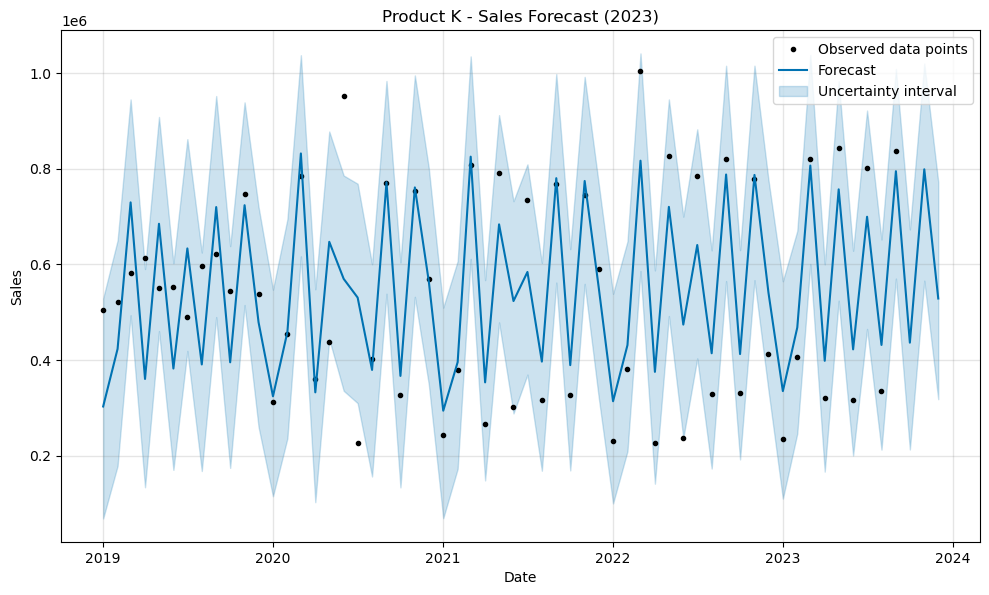

In [38]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product K - Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

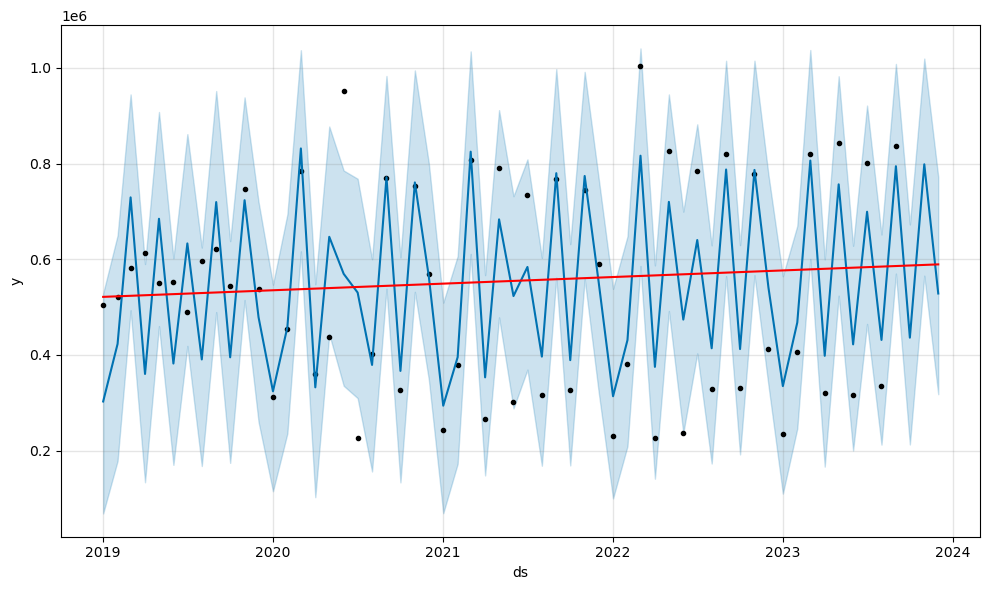

In [39]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

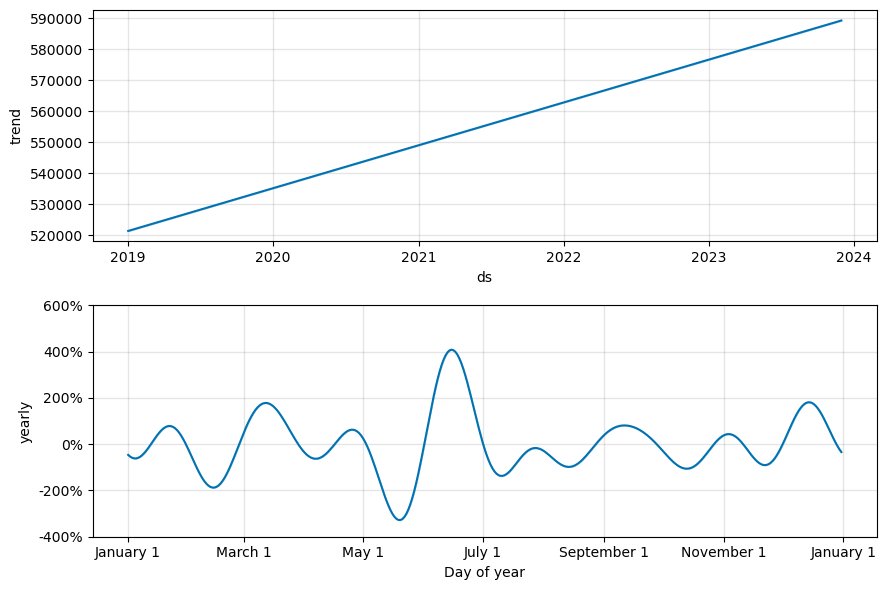

In [40]:
fig2 = model.plot_components(forecast)

In [41]:
forecasted_df

ds           yhat     yhat_lower    yhat_upper
57 2023-10-01  436050.667030  212792.480595  6.727502e+05
58 2023-11-01  798400.346378  565640.956806  1.019476e+06
59 2023-12-01  528361.988628  317854.291896  7.722387e+05

In [42]:
sales_k.tail(3) 

ds       y
57 2023-10-01  337462
58 2023-11-01  794412
59 2023-12-01  420417

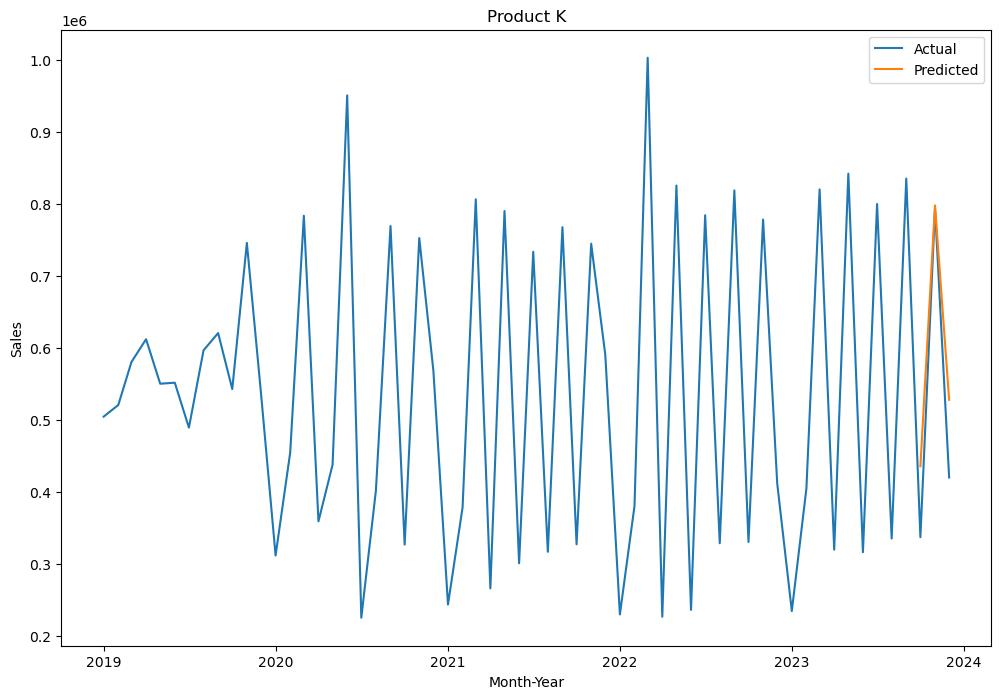

In [43]:
# Reset index of sales_b DataFrame
sales_k_reset_index = sales_k.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_k_reset_index['ds'], sales_k_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product K')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [44]:
#model evaluation

In [45]:
pred=forecasted_df['yhat']
test_df=test['y']

In [46]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 70174.001
MAPE - FB PROPHET: 0.185
MSE - FB PROPHET: 7129250914.440
RMSE - FB PROPHET: 84434.892


In [32]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

# Cross Validation

In [33]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [34]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse           rmse            mae      mape     mdape  \
0  20 days  6.945170e+10  263536.898774  217874.342654  0.461156  0.559341   
1  22 days  1.797666e+10  134077.065567  126302.557815  0.517787  0.480132   
2  23 days  4.271715e+10  206681.266323  194089.443788  0.556256  0.480132   
3  25 days  3.748569e+10  193612.208134  174230.907497  0.428625  0.362094   
4  27 days  9.724815e+09   98614.475969   98383.862968  0.344316  0.312027   
5  28 days  1.612602e+10  126988.274650  123543.136154  0.322857  0.312027   
6  47 days  5.146819e+10  226866.014733  203091.437411  0.339730  0.312027   
7  49 days  5.342918e+10  231147.528231  211586.996978  0.347510  0.404594   
8  51 days  4.455986e+10  211092.066410  164777.263102  0.289790  0.404594   
9  52 days  2.824268e+10  168055.575675  137654.164417  0.250791  0.314875   
10 53 days  2.338074e+10  152907.620602  109337.968252  0.153889  0.113889   
11 54 days  2.904022e+10  170411.922180  145359.843688  0.277242  0.314875   
12 56 days  6.561791e+09   81004.879903   63644.114634  0.178689  0.113889   
13 57 days  1.388946e+10  117853.555724  100679.110481  0.201838  0.183337   
14 58 days  8.938742e+09   94544.918987   73891.865466  0.110472  0.128862   
15 59 days  1.423396e+10  119306.152258  111210.859203  0.230126  0.183337   
16 78 days  7.736575e+10  278146.993702  213650.603023  0.680070  0.378179   
17 80 days  8.181182e+10  286027.659539  238491.961205  0.692115  0.378179   
18 81 days  4.759991e+10  218174.033799  178178.841274  0.203490  0.164998   
19 83 days  7.298121e+10  270150.351950  237148.622696  0.576532  0.350234   
20 85 days  5.592900e+10  236493.123155  206017.783272  0.547241  0.350234   
21 86 days  1.283172e+10  113277.171107  101778.144416  0.187633  0.134862   
22 88 days  1.479020e+10  121614.946277  109772.480602  0.284273  0.382974   
23 90 days  1.299969e+10  114016.182675  106684.375323  0.248093  0.105478   

       smape  coverage  
0   0.489510  0.333333  
1   0.397209  1.000000  
2   0.471389  0.666667  
3   0.388795  0.666667  
4   0.291937  1.000000  
5   0.289106  1.000000  
6   0.366446  0.666667  
7   0.372355  0.666667  
8   0.306928  0.666667  
9   0.247894  0.666667  
10  0.171640  0.666667  
11  0.272284  0.666667  
12  0.154181  1.000000  
13  0.185543  1.000000  
14  0.114102  1.000000  
15  0.213647  1.000000  
16  0.435658  0.666667  
17  0.455249  0.666667  
18  0.234807  0.666667  
19  0.435536  0.333333  
20  0.396309  0.500000  
21  0.170713  1.000000  
22  0.239298  1.000000  
23  0.215161  1.000000

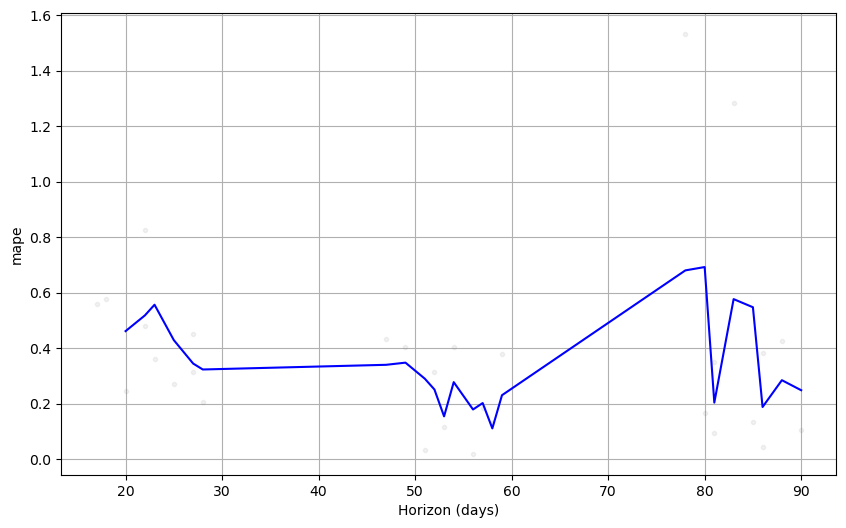

In [35]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [36]:
test_df

57    337462
58    794412
59    420417
Name: y, dtype: int64

In [37]:
pred

57    436050.667030
58    798400.346378
59    528361.988628
Name: yhat, dtype: float64

# FORECASTING

In [38]:
model_forecast = Prophet( changepoint_prior_scale= 0.001,seasonality_prior_scale=1.0, seasonality_mode ='multiplicative',
                interval_width=0.95)

In [39]:
model_forecast.fit(sales_k)

16:39:48 - cmdstanpy - INFO - Chain [1] start processing
16:39:48 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=3, freq='MS')  # 3 months in 2024

In [41]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [42]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [43]:
forecasted_f_df

ds           yhat     yhat_lower    yhat_upper
60 2024-01-01  345118.314457   90171.290177  5.713822e+05
61 2024-02-01  482087.791926  247725.990425  7.197546e+05
62 2024-03-01  894314.462079  648210.603224  1.135330e+06

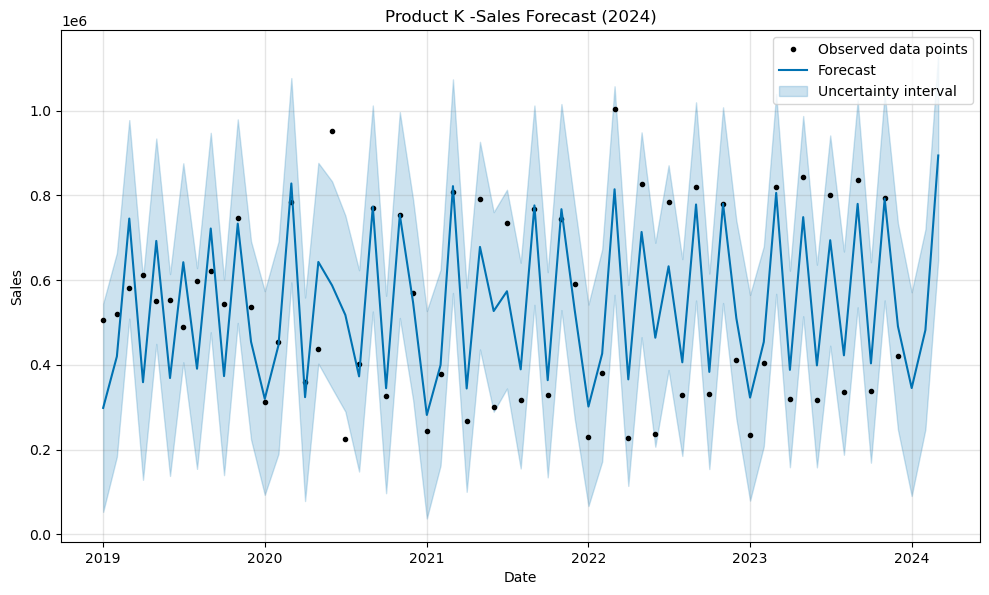

In [44]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product K -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [45]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [46]:
plot_components_plotly(model_forecast, forecast_f)